In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors
from imblearn import combine
from imblearn.combine import SMOTEENN

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\darre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('twitter.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [4]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [5]:
df.shape

(31962, 3)

In [6]:
print(df['tweet'][3])

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  


In [7]:
# Menghilangkan unnecessary noise pada tweet text, remove URL dan www pada tweet text
https_pattern = r"https:\/\/t.co\/[a-zA-Z0-9\-\.]{8}"
www_pattern = r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)"
repl = ""

print("unpreprocessed tweet: ", df['tweet'][1])

df.loc[:, 'tweet'] = df['tweet'].apply(lambda string: re.sub(https_pattern,
                                 repl,
                                 string,
                                 count=0,
                                 flags=0))

df.loc[:, 'tweet'] = df['tweet'].apply(lambda string: re.sub(www_pattern,
                                 repl,
                                 string,
                                 count=0, 
                                 flags=0))

print("preprocessed tweet: ", df['tweet'][1])

unpreprocessed tweet:  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
preprocessed tweet:  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked


In [8]:
# Remove twitter usernames handle
tweet_handle = r"@[A-Za-z0-9]+"
repl = ""

print("unpreprocessed tweet: ", df['tweet'][1])
df.loc[:, 'tweet'] = df['tweet'].apply(lambda string: re.sub(tweet_handle,
                                 repl, 
                                 string, 
                                 count=0, 
                                 flags=0))

print("preprocessed tweet: ", df['tweet'][1])


unpreprocessed tweet:  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
preprocessed tweet:    thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked


In [9]:
# Remove Non-ASCII characters dari tweet
non_ascii_pattern = r'[^\x00-\x7F]+'

print("unpreprocessed tweet: ", df['tweet'][3])
df['tweet'] = df['tweet'].apply(lambda string: re.sub(non_ascii_pattern, "", string))

print("preprocessed tweet: ", df['tweet'][3])

unpreprocessed tweet:  #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
preprocessed tweet:  #model   i love u take with u all the time in ur!!!   


In [10]:
# Tokenisasi tweet text dengan nltk (lowercase semua kata supaya tidak ada kata yang sama dengan huruf besar dan kecil)
df['tweet'] = df['tweet'].apply(lambda x: word_tokenize(x.lower()))

In [11]:
# Embedding tweet text dengan Word2Vec
model = Word2Vec(df["tweet"], vector_size=100, window=5, min_count=1, workers=4)
model.train(df["tweet"], total_examples=1, epochs=1)

(378275, 530273)

In [12]:
# Melihat embedding dari kata "hate"
# vector = model.wv[["hate"]]
# print(vector)

# Menghitung rata-rata embedding dari setiap kata dalam tweet
def get_tweet_embedding(tokenized_tweet):
    embeddings = [model.wv[word] for word in tokenized_tweet if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

df['tweet'] = df['tweet'].apply(get_tweet_embedding)

In [13]:
# Memisahkan variabel feature dan target
X = df.drop(columns=['label'])
X = np.vstack(df['tweet'].values)
y = df['label'].values

0    29720
1     2242
Name: count, dtype: int64


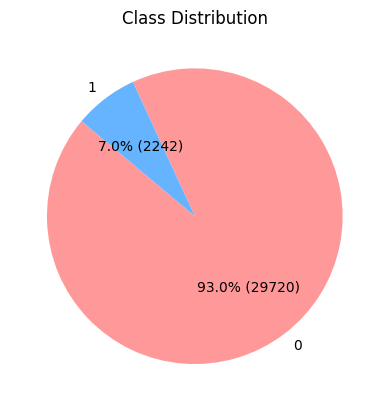

In [14]:
y_series = pd.Series(y)

class_dist = y_series.value_counts()
print(class_dist)

# Untuk melihat value count dari class distribution
def num(values):
    def format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}% ({val})'
    return format

plt.pie(class_dist, labels=class_dist.index, autopct=num(class_dist), startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution')
plt.show()

In [15]:
# Perform SMOTEENN (Synthetic minority oversampling dengan edited nearest neighbors) untuk mengatasi imbalanced data
smote = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [16]:
# Cek class distribution setelah resampling
y_seriesresampled = pd.Series(y_resampled)
class_distresampled = y_seriesresampled.value_counts()
print(class_distresampled)

1    29660
0    21865
Name: count, dtype: int64


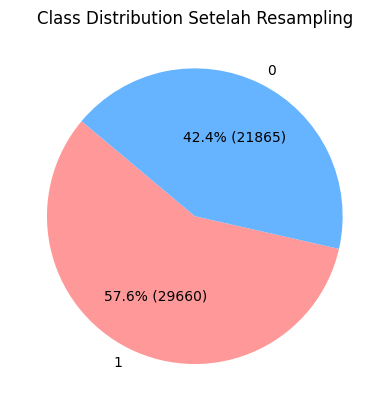

In [17]:
# Pie chart untuk melihat class distribution setelah resampling
plt.pie(class_distresampled, labels=class_distresampled.index, autopct=num(class_distresampled), startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution Setelah Resampling')
plt.show()

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)  

# Standardize the data
SScaler = StandardScaler()
X_train = SScaler.fit_transform(X_train)
X_test = SScaler.transform(X_test)

In [19]:
dtree_clf = DecisionTreeClassifier(random_state=42, criterion='entropy')
dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

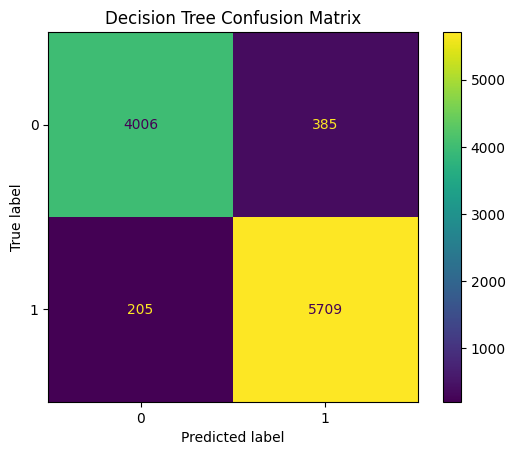

In [20]:
# Confusion Matrix
dtree_confusion_matrix = confusion_matrix(y_test, dtree_clf.predict(X_test))
ConfusionMatrixDisplay(dtree_confusion_matrix).plot()
plt.title('Decision Tree Confusion Matrix')
plt.show()

In [21]:
dtree_prd = dtree_clf.predict(X_test)
dtree_clfreport = classification_report(y_test, dtree_prd)
print(dtree_clfreport)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4391
           1       0.94      0.97      0.95      5914

    accuracy                           0.94     10305
   macro avg       0.94      0.94      0.94     10305
weighted avg       0.94      0.94      0.94     10305



In [22]:
pd.DataFrame({'Decision Tree': dtree_prd, 'Test': y_test})

,Decision Tree,Test
0,1,0
1,1,0
2,1,1
3,0,0
4,0,0
...,...,...
10300,1,1
10301,1,1
10302,0,0
10303,0,0


In [23]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42, max_depth=7)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, random_state=42)

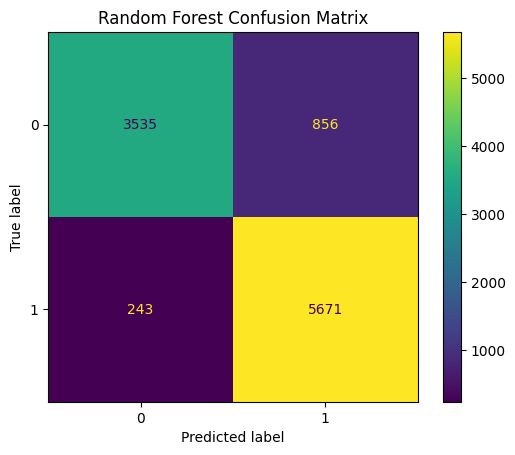

In [24]:
# Confusion Matrix
rf_confusion_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))
ConfusionMatrixDisplay(rf_confusion_matrix).plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

In [25]:
# Classification Report
rf_prd = rf_clf.predict(X_test)
rf_clfreport = classification_report(y_test, rf_prd)
print(rf_clfreport)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4391
           1       0.87      0.96      0.91      5914

    accuracy                           0.89     10305
   macro avg       0.90      0.88      0.89     10305
weighted avg       0.90      0.89      0.89     10305



In [26]:
# Prediksi dengan Random Forest
pd.DataFrame({'Random Forest': rf_prd, 'Test': y_test})

,Random Forest,Test
0,1,0
1,1,0
2,1,1
3,0,0
4,1,0
...,...,...
10300,1,1
10301,1,1
10302,1,0
10303,0,0


In [27]:
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

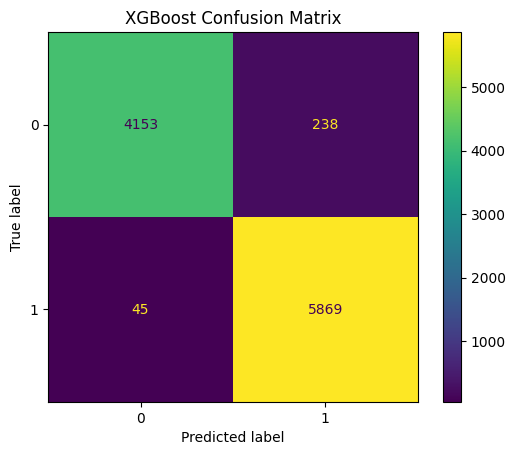

In [28]:
# Confusion Matrix XGBoost
xgb_confusion_matrix = confusion_matrix(y_test, xgb_clf.predict(X_test))
ConfusionMatrixDisplay(xgb_confusion_matrix).plot()
plt.title('XGBoost Confusion Matrix')
plt.show()

In [29]:
xgb_prd = xgb_clf.predict(X_test)
xgb_clfreport = classification_report(y_test, xgb_prd)
print(xgb_clfreport)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4391
           1       0.96      0.99      0.98      5914

    accuracy                           0.97     10305
   macro avg       0.98      0.97      0.97     10305
weighted avg       0.97      0.97      0.97     10305



In [30]:
# Prediksi dengan XGBoost
pd.DataFrame({'XGBoost': xgb_prd, 'Test': y_test})

,XGBoost,Test
0,1,0
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
10300,1,1
10301,1,1
10302,0,0
10303,0,0
